In [1]:
%reload_ext autoreload

In [82]:
# Packages needed

#!pip install "tabulate" "pandas_summary" "imblearn" "fastai" "joblib"
#!pip install fastai==0.7.0

In [83]:
# Imports

%load_ext autoreload
%autoreload 2

%matplotlib inline
import sys
import pandas as pd
from fastai.imports import *
from fastai.structured import *
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib

#import numpy as np
#import random
#from matplotlib import pyplot
#from pandas_summary import DataFrameSummary
#from IPython.display import display
#from tabulate import tabulate
#from sklearn.model_selection import GridSearchCV
#from scipy.stats.mstats import mode, gmean, hmean
#from sklearn import metrics

#set_plot_sizes(12,14,16)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
sys.path.append('../lib')
import utils
import preprocessing

In [85]:
# Load in data

PATH = "../data/"
df_raw = pd.read_csv(f'{PATH}churn.csv', low_memory=False, 
                     parse_dates=['canceldate', 'licence_registration_date', 'golive_date'])

In [86]:
print(len(df_raw), df_raw.shape)
df_processed = preprocessing.prepare_data(df_raw)
print(len(df_processed), df_processed.shape)

5889 (5889, 38)
5889 (5889, 101)


In [87]:
utils.data_summary(df_processed)

Column                                        Min              Max              Mean     Trimmed Mean          Median             Std            cv
-------------------------------  ----------------  ---------------  ----------------  ---------------  --------------  --------------  ------------
days_active                           0             2269               681.559          612.713         527             566.071         0.830554
golive_days                          -1             1643                67.6303          33.6183          4             142.993         2.11433
cases_total                           1              200                 7.07624          5.18141         5               9.51299       1.34436
cases_open                            0               18                 0.39803          0.146404        0               1.05238       2.64398
cases_closed                          0               18                 0.39803          0.146404        0               1.052

In [88]:
df_filtered = df_processed[df_processed.licence_registration_Year >2017]
print(len(df_filtered), df_filtered.shape)

1351 (1351, 101)


In [96]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)
        
#display_all(df_filtered)

print(len(df_filtered[df_filtered.nps_detractor == 1]),len(df_filtered[df_filtered.nps_passive == 1]),len(df_filtered[df_filtered.nps_promoter == 1]))







1256 30 35


In [97]:
print(df_filtered.licence_registration_Year.head(), df_filtered.licence_registration_Year.tail())

4538    2018
4539    2018
4540    2018
4541    2018
4542    2018
Name: licence_registration_Year, dtype: int64 5884    2019
5885    2019
5887    2019
5886    2019
5888    2019
Name: licence_registration_Year, dtype: int64


In [98]:
len(df_filtered[df_filtered.churned == 1]), len(df_filtered[df_filtered.churned == 0])

(412, 939)

In [99]:
df_trn, y_trn, nas = proc_df(df_filtered, 'churned')
print(len(df_trn), df_trn.shape)

1351 (1351, 104)


/Users/justinhennessy/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [100]:
def split_vals(a,n): return a[:n], a[n:]

n_valid = 500
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

In [101]:
# Fix the dataset imbalance

sm = SMOTE(random_state=12, ratio = 1.0)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
X_train_res.shape

(1040, 104)

In [102]:
len(df_filtered[df_filtered.churned == 1]), len(df_filtered[df_filtered.churned == 0])

(412, 939)

In [103]:
m = RandomForestClassifier(
    n_estimators=200,
    min_samples_leaf=2, 
    max_features='sqrt',
    n_jobs=-1, 
    #oob_score=True,
    max_depth=3,
    bootstrap=False,
    criterion='entropy',
    class_weight={0: 4, 1: 1}
    )

m.fit(X_train_res, y_train_res)

y_pred = m.predict(X_valid)
print(utils.uber_score(y_valid, y_pred))
utils.conf_matrix(y_valid, y_pred)

# Save to file in the current working directory
joblib_file = "churn_model.pkl"
joblib.dump(m, joblib_file)

precision, recall, f1_score, accuracy, cohen_kappa_score, mean abs error
[0.7317073170731707, 0.37037037037037035, 0.4918032786885245, 0.876, 0.429706758894735, 0.124]
[[408  11]
 [ 51  30]]


['churn_model.pkl']

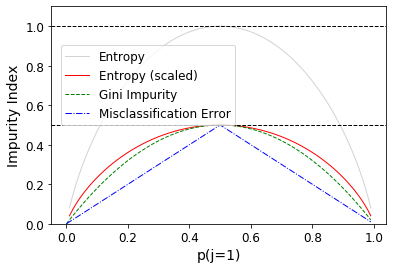

In [44]:
import matplotlib.pyplot as plt
import numpy as np

def gini(p):
   return (p)*(1 - (p)) + (1 - p)*(1 - (1-p))

def entropy(p):
   return - p*np.log2(p) - (1 - p)*np.log2((1 - p))

def classification_error(p):
   return 1 - np.max([p, 1 - p])

x = np.arange(0.0, 1.0, 0.01)
ent = [entropy(p) if p != 0 else None for p in x]
scaled_ent = [e*0.5 if e else None for e in ent]
c_err = [classification_error(i) for i in x]

fig = plt.figure()
ax = plt.subplot(111)

for j, lab, ls, c, in zip(
      [ent, scaled_ent, gini(x), c_err],
      ['Entropy', 'Entropy (scaled)', 'Gini Impurity', 'Misclassification Error'],
      ['-', '-', '--', '-.'],
      ['lightgray', 'red', 'green', 'blue']):
   line = ax.plot(x, j, label=lab, linestyle=ls, lw=1, color=c)

ax.legend(loc='upper left', bbox_to_anchor=(0.01, 0.85),
         ncol=1, fancybox=True, shadow=False)

ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')

plt.ylim([0, 1.1])
plt.xlabel('p(j=1)')
plt.ylabel('Impurity Index')
plt.show()